In [1]:
from IPython.html import widgets
%load_ext rpy2.ipython
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
import numpy as np
from base import plotting
from base.classifiers import OnevsallContinuous
import base.classifiers.onevsall as oa
import glob
import pandas as pd
from base import tools
from scipy import stats
import itertools
import seaborn as sns
import mpld3
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pylab

In [3]:
from neurosynth.base.dataset import Dataset
dataset = Dataset.load("../data/datasets/abs_60topics_filt_jul.pkl")

In [4]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
roc_scorer = make_scorer(roc_auc_score)

In [19]:
from sklearn.cross_validation import Bootstrap
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import RidgeClassifier

In [6]:
GNB_clf_cog = [OnevsallContinuous.load(clf + "/classifier.pkl") for clf in glob.glob("../results/coact_kmeans*GNB*cog*")]

In [7]:
clfs = []
for clf in GNB_clf_cog:
    if len(clf.data) < 100:
        clfs.append((clf, len(clf.data)))

In [8]:
clfs = clfs[0:4]

In [9]:
def n_acc_parallel(args):
    (data, classifier, minimum, maximum, step, n_iter, scorer), reg = args
    X, y = data[reg]
    res = []
    for i in np.arange(minimum, maximum, step):
        
        cv = ShuffleSplit(y.shape[0], n_iter=n_iter, train_size=i*.8, test_size=i*.2)
        for train_index, test_index in cv:
            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]

            classifier.fit(X_train, y_train)
            res.append([reg, i, scorer(classifier, X_test, y_test)])
    return res


In [20]:
def n_by_accuracy(clf, scorer, minimum=0.1, maximum=0.5, step=0.1, n_iter = 100, processes=8):
    from base.tools import ProgressBar
    if processes > 1:
        from multiprocessing import Pool
        pool = Pool(processes=processes)
    else:
        pool = itertools

    pb = ProgressBar(clf.data.shape[0], start=True)

    overall_res = []


    for result in pool.imap(n_acc_parallel, itertools.izip(itertools.repeat((
                    clf.data, RidgeClassifier(), minimum, maximum, step, n_iter, scorer)), range(0, len(clf.data)))):
        pb.next()
        for row in result:
            overall_res.append(row)
    return pd.DataFrame(overall_res, columns=['region', 'train_size', 'score'])

In [21]:
all_ns = []
for clf in clfs:
    print clf[1]
    reg_res = n_by_accuracy(clf[0], roc_scorer, minimum=0.1, maximum=1, step=0.15, n_iter = 100)
    reg_res['n_regs'] = clf[1]
    all_ns.append(reg_res)


    

20
[##########] 100%
40
[##########] 100%
60
[##########] 100%
80
[##########] 100%


In [13]:
all_ns = pd.concat(all_ns)

In [14]:
import seaborn as sns

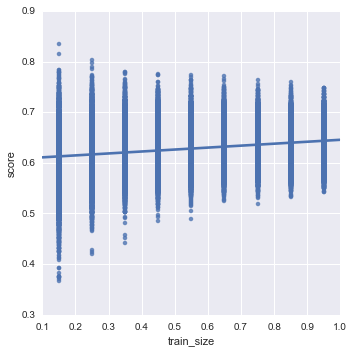

In [15]:
sns.lmplot('train_size', 'score', all_ns)

In [16]:
mean_all_ns = all_ns.groupby(['region', 'train_size', 'n_regs']).mean().reset_index()

In [17]:
%Rpush mean_all_ns

geom_smooth: method="auto" and size of largest group is <1000, so using loess. Use 'method = x' to change the smoothing method.
geom_smooth: method="auto" and size of largest group is <1000, so using loess. Use 'method = x' to change the smoothing method.


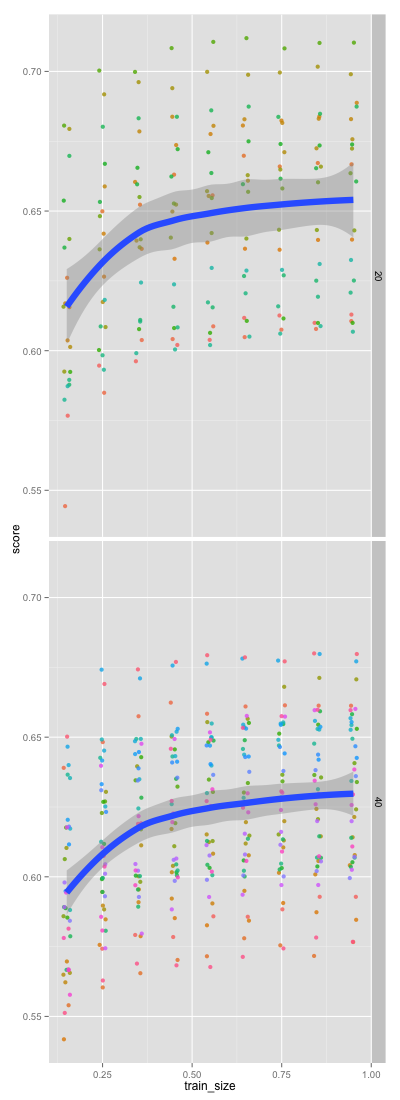

In [18]:
%%R -w 400 -h 1100
library(ggplot2)
ggplot(mean_all_ns, aes(train_size, score)) + 
geom_point(aes(color=factor(region)), position=position_jitter(width=0.01), alpha=0.8) + geom_smooth(size = 3) +
facet_grid(n_regs~.) + theme(legend.position='none')

# ggsave('../reports/ns_classify_paper/20_80_sim.pdf')

In [33]:
mean_all_ns.groupby(['train_size', 'n_regs']).mean()

region     score
train_size n_regs                  
0.05       20         9.5  0.571738
           40        19.5  0.554234
           60        29.5  0.547275
           80        39.5  0.542855
0.15       20         9.5  0.624180
           40        19.5  0.602178
           60        29.5  0.588595
           80        39.5  0.582911
0.25       20         9.5  0.639784
           40        19.5  0.615859
           60        29.5  0.601651
           80        39.5  0.596470
0.35       20         9.5  0.645805
           40        19.5  0.621459
           60        29.5  0.607634
           80        39.5  0.601888
0.45       20         9.5  0.650055
           40        19.5  0.624753
           60        29.5  0.610531
           80        39.5  0.604845